# Reading the ROOT files

In [1]:
# %matplotlib notebook

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, InputLayer
from tensorflow.keras.preprocessing import sequence

In [3]:
import uproot
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
import awkward as ak
from mpl_toolkits.mplot3d import axes3d 
from matplotlib.colors import LogNorm
import IPython
from sklearn import metrics

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [6]:
from scipy.stats import norm
import scipy.interpolate as interpolate
from scipy.ndimage import median as med

In [7]:
pmtpos = np.loadtxt('pmtpositions.csv', delimiter=',')
pmtpos = np.vstack((np.array([0, 0, 0]), pmtpos))

In [9]:
ibd = ak.from_json('data/ibd.json')
fastn = ak.from_json('data/fastn.json')

Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

In [125]:
data = ibd[ibd['subid']==0]
b1 = data.beta_one
b2 = data.beta_two
b3 = data.beta_three
b4 = data.beta_four
b5 = data.beta_five
b6 = ibd.beta_six

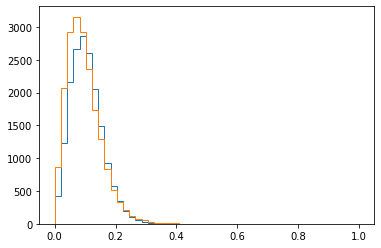

In [131]:
kw = dict(bins=np.linspace(0,1, 50), histtype='step')
plt.hist(fastn[fastn['subid']>0].beta_two, **kw)
plt.hist(data.beta_three, **kw)
plt.show()

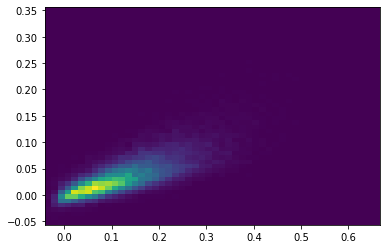

In [99]:
kw = dict(bins=50)
plt.hist2d(np.array(ibd.beta_one), np.array(ibd.beta_three), **kw)
plt.hist2d(np.array(fastn.beta_one), np.array(fastn.beta_three), **kw)

plt.show()

Make sure all times that are larger than ~600 us are set to some constant, e.g. 500 us. 
<br>
This is because the rates are arbitrary in the case of us using these samples -- these are just injected rates. 

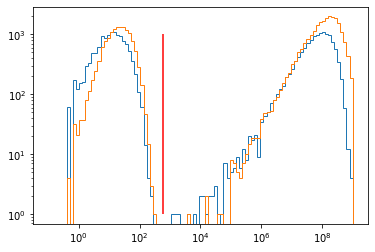

In [103]:
kw = dict(bins=np.logspace(-1, 9, 100), histtype='step')
plt.hist(fastn['dt_next_us'],**kw )
plt.hist(ibd['dt_next_us'],**kw )

plt.vlines(600, 1, 1e3, color='red')
plt.loglog()
plt.show()

In [106]:
#do we need to also remove the distance information? 
for data in [fastn, ibd]:
    data = calcr(data)
    for t, varbls in zip(['dt_prev_us', 'dt_next_us'], [prev_vars, post_vars]):
        prox_mask = data[t]<600
        for key in varbls: 
            data[key] = ak.where(prox_mask, data[key], -1e5)

In [11]:
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

In [10]:
dimensions = [
    'n9', 'n9_prev', 'n9_next',
    'x', 'y', 'z',  'r',
    'id_plus_dr_hit', 'inner_hit_prev', 'inner_hit_next',
    'good_dir', 'good_dir_prev', 'good_dir_next',
    'good_pos','good_pos_prev', 'good_pos_next',
#     'distpmt', 
    'closestPMT', 'closestPMT_prev', 'closestPMT_next', 
    'drPrevr', 'dzPrevz', 'drNextr', 'dzNextz',
     'dt_prev_us', 'dt_next_us',
    'azimuth_ks', 'azimuth_ks_prev','azimuth_ks_next',
    'n100', 'pe', 
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
    'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]

In [12]:
samples = np.min([len(fastn), len(ibd)])

In [13]:
# eplus = get_dims(positrons, dimensions=dimensions)[:samples]
fastns = get_dims(fastn, dimensions=dimensions)[:samples]
ibds = get_dims(ibd, dimensions=dimensions)[:samples]

Remaining variables selected for analysis: 42
Remaining variables selected for analysis: 42


In [14]:
y = np.zeros(len(fastns))
y = np.append(y, np.ones(len(ibds)))

In [15]:
x = pd.concat([ak.to_pandas(fastns), ak.to_pandas(ibds)])

In [16]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25) 

In [17]:
X_save = X_test

In [18]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
#     n_estimators=200, max_depth=10
)

#Train the model using the training sets
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [20]:
y_test_prob = clf.predict_proba(X_test)

In [21]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 100.00%
Test Accuracy: 83.31%


In [22]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

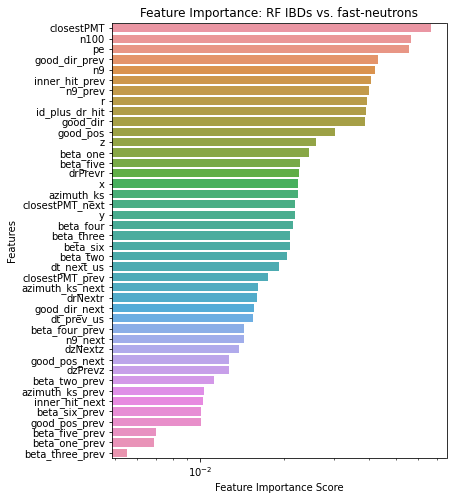

In [23]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF IBDs vs. fast-neutrons")
# plt.legend()
plt.show()

In [24]:
scores = y_test_prob[:,1]

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

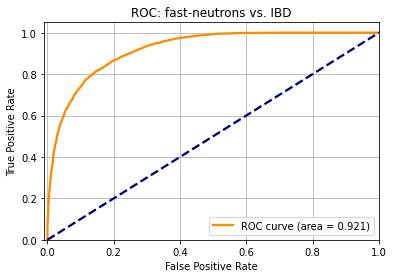

In [27]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: fast-neutrons vs. IBD')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
# plt.xlim([1e-6, 1.0])
# plt.ylim([1e-2, 1.05])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

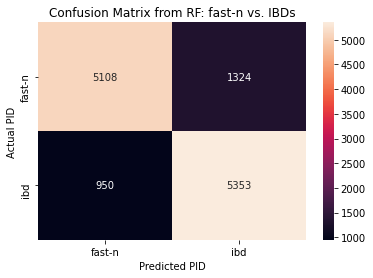

In [124]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: fast-n vs. IBDs')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

cmlabels = ['fast-n', 'ibd']
ax.xaxis.set_ticklabels(cmlabels)
ax.yaxis.set_ticklabels(cmlabels)

plt.show()

In [85]:
wrong = X_save[y_test_pred!=y_test]

In [86]:
rightpred = y_test[y_test_pred!=y_test]

In [87]:
wrongfastn = fastn[wrong[rightpred==0].index]
wrongibd = ibd[wrong[rightpred==1].index]

## RF with multiple classes

In [28]:
all_data = ak.concatenate([ibd, fastn])

In [29]:
fn = all_data['code']==2
invbeta = all_data['code']==1
id0 = all_data['subid']==0
id1p = all_data['subid']>0 # >0 changes things 

In [30]:
ibd0_mask = ak.from_iter([all(t) for t in zip(invbeta, id0)])
ibd1_mask = ak.from_iter([all(t) for t in zip(invbeta, id1p)])
fastn0_mask = ak.from_iter([all(t) for t in zip(fn, id0)])
fastn1_mask = ak.from_iter([all(t) for t in zip(fn, id1p)])

In [31]:
samples = min([ak.count_nonzero(fn), 
#               ak.count_nonzero(fastn1_mask), 
              ak.count_nonzero(ibd0_mask), 
              ak.count_nonzero(ibd1_mask)])

In [32]:
x1 = all_data[fn][:samples]
# x1 = ak.concatenate((x1, all_data[fastn1_mask][:samples]), axis=0)
x1 = ak.concatenate((x1, all_data[ibd0_mask][:samples]), axis=0)
x1 = ak.concatenate((x1, all_data[ibd1_mask][:samples]), axis=0)

In [33]:
y1 = np.zeros(3*samples)
y1[samples:2*samples] = 1
y1[2*samples:3*samples] = 2
# y1[3*samples:] = 2

In [34]:
# eplus = get_dims(positrons, dimensions=dimensions)[:samples]
x = get_dims(x1, dimensions=dimensions)
x = ak.to_pandas(x)

Remaining variables selected for analysis: 42


In [35]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y1, test_size=0.25, random_state=43) 

In [36]:
X_save = X_test

In [37]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [38]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
#     n_estimators=200, max_depth=10
)

#Train the model using the training sets
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [39]:
y_test_prob = clf.predict_proba(X_test)

In [40]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 100.00%
Test Accuracy: 70.64%


In [41]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

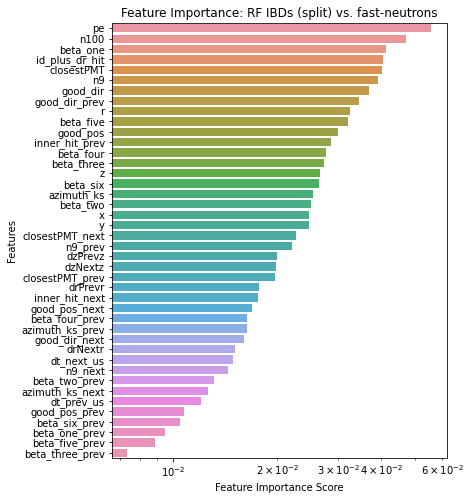

In [43]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF IBDs (split) vs. fast-neutrons")
# plt.legend()
plt.show()

In [44]:
scores = clf.predict_proba(X_test)

In [45]:
y_pred_2 = np.argmax(scores, axis=1)
# y_test_2 = np.argmax(y_test, axis=1)

In [46]:
# y_pred = np.round(scores)

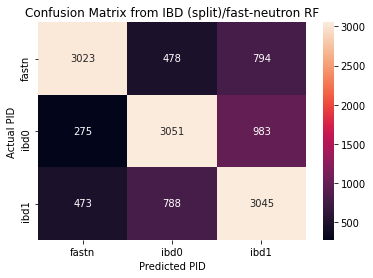

In [47]:
confmat = confusion_matrix(y_test, y_pred_2)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from IBD (split)/fast-neutron RF')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['fastn', 'ibd0', 'ibd1'])
ax.yaxis.set_ticklabels(['fastn', 'ibd0', 'ibd1'])

plt.show()

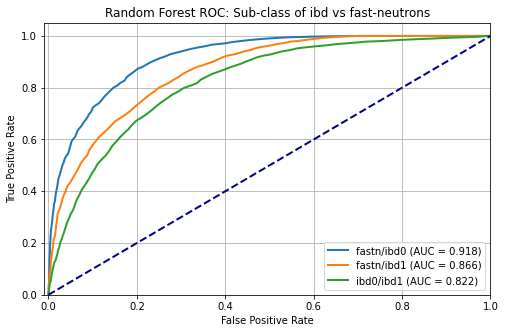

In [48]:
cat1 = [0, 0, 0, 1, 1, 2]
cat2 = [1, 2, 3, 2, 3, 3]
labels = ['fastn0/fastn1', 'fastn0/ibd0', 'fastn0/ibd1', 
          'fastn1/ibd0', 'fastn1/ibd1', 
          'ibd0/ibd1', 
         ]
cat1 = [0, 0, 1]
cat2 = [1, 2, 2]
labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1', 
#           'fastn1/ibd0', 'fastn1/ibd1', 
#           'ibd0/ibd1', 
         ]
plt.figure(figsize=(8,5))
for i, j, label in zip(cat1, cat2, 
                        labels,
                         ):
    mask = [any(t) for t in zip(y_test==i, y_test==j)]
    prob = scores[:, j][mask]
    
    guesses = y_test[mask]
    guesses = guesses - np.min(guesses)
    guesses = guesses/np.max(guesses)

    fpr, tpr, thresholds = roc_curve(guesses, prob)
        
    auc = roc_auc_score(y_test[mask], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC: Sub-class of ibd vs fast-neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.show()

## RNN Prep

Add in residual time and pmt info (can cut for promptness in mask if wanted. Now not doing.) 

In [153]:
delaytime = 1e5
c = 21.8 #cm/ns

for j, data in enumerate([ibd, fastn]):
    channels = []
    charges = []
    timess = []
    chn = data['channel']    
    print('set %i of %i'%(j+1, 3))
    times = data['hittime']-800.
    for i, ht in enumerate(data['hittime']): 
        if i%10_000==0:
            print('-----Processing sample %i of %i-----'%(i, len(data)))
        xyz = pmtpos[chn[i]] #cm
        vertex = [data['x'][i]/10., data['y'][i]/10., data['z'][i]/10.] #cm
        dist = np.sqrt(np.sum((xyz - vertex)**2, axis=1)) # cm
        res = times[i] - dist/c
        promptmask = np.logical_and(res<delaytime, res>-1*delaytime)
        channels.append(data['channel'][i][promptmask])
        charges.append(data['pmtcharge'][i][promptmask])
        timess.append(res[promptmask])
    data['restime'] = ak.Array(timess)
    data['promptchan'], data['promptcharge'], data['prompttime'] = ak.Array(channels), ak.Array(charges), ak.Array(timess)

set 1 of 3
-----Processing sample 0 of 36834-----
-----Processing sample 10000 of 36834-----
-----Processing sample 20000 of 36834-----
-----Processing sample 30000 of 36834-----
set 2 of 3
-----Processing sample 0 of 25469-----
-----Processing sample 10000 of 25469-----
-----Processing sample 20000 of 25469-----


------

In [167]:
def prep_net_data(data_to_manipulate, 
                  prompt=True, restime=True,
                  maxlen=100):
    X = []
    y = np.array([])
    
    if prompt==True:
        keys = ['promptchan', 'promptcharge', 'prompttime']
    elif prompt==False:
        keys = ['channel', 'pmtcharge', 'hittime']
    if restime==True:
        keys.append('restime')
        
    diminput = len(keys)
    for d, dat in enumerate(data_to_manipulate):
        print('Running set %i of %i'%(d+1, len(data_to_manipulate)))
        new = np.empty(shape=(len(dat), maxlen, diminput+2))

        chn = sequence.pad_sequences(dat[keys[0]]+1, maxlen=maxlen, 
                                     padding='post', 
                                     dtype='int32')
        chrg = sequence.pad_sequences(dat[keys[1]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        
        xyz = pmtpos[chn]+1 #since value of 0 has meaning..
        
        time = sequence.pad_sequences(dat[keys[2]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        new[:,:,0] = chrg
        new[:,:,1] = time    
        new[:,:,2:5] = xyz+1
        
        if restime==True:
            res_times = sequence.pad_sequences(dat[keys[3]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
            new[:,:,5] = res_times
            
        if len(X)>0:
            X = np.append(X, new, axis=0)
        else: 
            X = new
        y=np.append(y, d*np.ones(len(new)))    
    return X, y

In [169]:
samples = np.min([len(fastn), len(ibd)])
data_to_manipulate = [fastn[:samples], ibd[:samples]]

In [170]:
X, y = prep_net_data(data_to_manipulate, prompt=True, restime=True, maxlen=200)

Running set 1 of 2
Running set 2 of 2


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [175]:
regressor = Sequential()
input_shape = X.shape[1:]
regressor.add(InputLayer(input_shape=input_shape))
# regressor.add(LSTM(units=256, 
#                    return_sequences=True, 
#                    dropout=0.1,
#                   ))  

regressor.add(LSTM(units=128, 
                   return_sequences=True, 
                   dropout=0.1, 
                   
                  ))

regressor.add(LSTM(units=64, 
                   return_sequences=True, 
                  dropout=0.0, 
                  ))

# regressor.add(LSTM(units=32, 
#                    return_sequences=False, 
#                   dropout=0.0, 
#                   ))

# regressor.add(Dense(128, 
#                     activation='relu', 
#                    ))

# regressor.add(Dropout(0.2))

# regressor.add(Dense(32, 
#                    activation='relu', 
#                    ))

regressor.add(Dense(1, activation='sigmoid'))

regressor.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [176]:
regressor.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200, 128)          69120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 64)           49408     
_________________________________________________________________
dense_28 (Dense)             (None, 200, 1)            65        
Total params: 118,593
Trainable params: 118,593
Non-trainable params: 0
_________________________________________________________________


In [177]:
hisconcatenatey = regressor.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=10, batch_size=64, 
         )

Epoch 1/10
597/597 [==============================] - 245s 402ms/step - loss: 0.6904 - accuracy: 0.5235 - val_loss: 0.6878 - val_accuracy: 0.5322
Epoch 2/10
597/597 [==============================] - 241s 404ms/step - loss: 0.6831 - accuracy: 0.5425 - val_loss: 0.6653 - val_accuracy: 0.5880
Epoch 3/10
 21/597 [>.............................] - ETA: 3:19 - loss: 0.6647 - accuracy: 0.5872

KeyboardInterrupt: 

In [560]:
import lhsmdu

In [561]:
k = lhsmdu.sample(2, 20)

In [570]:
k = np.array(k)

## Trying RNN With multiple sub-classes 

In [221]:
all_data = ak.concatenate(data_to_manipulate)

In [327]:
fn = all_data['code']==2
invbeta = all_data['code']==1
id0 = all_data['subid']==0
id1p = all_data['subid']==1 # >0 changes things 

In [328]:
sm1 = all_data['code']==2
sm2 = all_data['subid'] ==0

In [329]:
ibd0_mask = ak.from_iter([all(t) for t in zip(invbeta, id0)])
ibd1_mask = ak.from_iter([all(t) for t in zip(invbeta, id1p)])
fastn0_mask = ak.from_iter([all(t) for t in zip(fn, id0)])
fastn1_mask = ak.from_iter([all(t) for t in zip(fn, id1p)])

In [330]:
samples = min([ak.count_nonzero(fastn0_mask), 
              ak.count_nonzero(fastn1_mask), 
              ak.count_nonzero(ibd0_mask), 
              ak.count_nonzero(ibd1_mask)])

In [325]:
x1 = all_data[fastn0_mask][:samples]
x1 = ak.concatenate((x1, all_data[fastn1_mask][:samples]))
x1 = ak.concatenate((x1, all_data[ibd0_mask][:samples]))
x1 = ak.concatenate((x1, all_data[ibd1_mask][:samples]))

In [334]:
len(x1)

30748

In [335]:
data_to_manipulate = [all_data[fastn0_mask][:samples], all_data[fastn1_mask][:samples],
                     all_data[ibd0_mask][:samples], all_data[ibd1_mask][:samples]
                     ]

In [336]:
X, y = prep_net_data(data_to_manipulate, prompt=True, restime=True, maxlen=200)

Running set 1 of 4
Running set 2 of 4
Running set 3 of 4
Running set 4 of 4


In [235]:
y1 = ak.where(fastn0_mask, 0, 0)
y1 = ak.where(fastn1_mask, 1, y1)
y1 = ak.where(ibd0_mask, 2, y1)
y1 = ak.where(ibd1_mask, 3, y1)

In [240]:
yy = ak.to_numpy(y1)

In [340]:
a = np.array(y.astype(int))
b = np.zeros((a.size, a.max()+1), dtype='int32')
b[np.arange(a.size),a] = 1
y = b

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [367]:
regressor = Sequential()
input_shape = X.shape[1:]
regressor.add(InputLayer(input_shape=input_shape))
regressor.add(LSTM(units=256, 
                   return_sequences=True, 
                   dropout=0.1,
                  ))  

regressor.add(LSTM(units=128, 
                   return_sequences=True, 
                   dropout=0.1, 
                   
                  ))
regressor.add(LSTM(units=64, 
                   return_sequences=False, 
                   dropout=0.1, 
                   
                  ))
regressor.add(Dense(32, activation='relu'))
# regressor.add(LSTM(units=50, return_sequences=True))
# regressor.add(Dropout(0.2))

regressor.add(Dense(4, activation='softmax'))

regressor.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [368]:
regressor.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 200, 256)          269312    
_________________________________________________________________
lstm_14 (LSTM)               (None, 200, 128)          197120    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 132       
Total params: 518,052
Trainable params: 518,052
Non-trainable params: 0
_________________________________________________________________


In [369]:
history = regressor.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=20, batch_size=64, 
         )

Epoch 1/20
326/326 [==============================] - 311s 941ms/step - loss: 1.3789 - accuracy: 0.2665 - val_loss: 1.3648 - val_accuracy: 0.2699
Epoch 2/20
326/326 [==============================] - 306s 940ms/step - loss: 1.3322 - accuracy: 0.3084 - val_loss: 1.2815 - val_accuracy: 0.3747
Epoch 3/20
326/326 [==============================] - 305s 937ms/step - loss: 1.2838 - accuracy: 0.3661 - val_loss: 1.2805 - val_accuracy: 0.3842
Epoch 4/20
 10/326 [..............................] - ETA: 4:14 - loss: 1.2629 - accuracy: 0.4047

KeyboardInterrupt: 

In [370]:
scores = regressor.predict(X_test)
y_pred = np.round(scores)

In [371]:
y_pred_2 = np.argmax(scores, axis=1)
y_test_2 = np.argmax(y_test, axis=1)

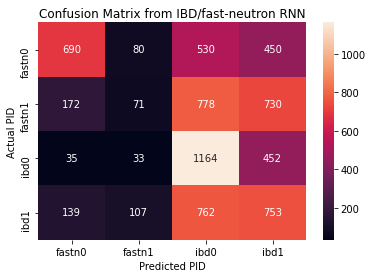

In [374]:
confmat = confusion_matrix(y_test_2, y_pred_2)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from IBD/fast-neutron RNN')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['fastn0', 'fastn1', 'ibd0', 'ibd1'])
ax.yaxis.set_ticklabels(['fastn0', 'fastn1', 'ibd0', 'ibd1'])

plt.show()

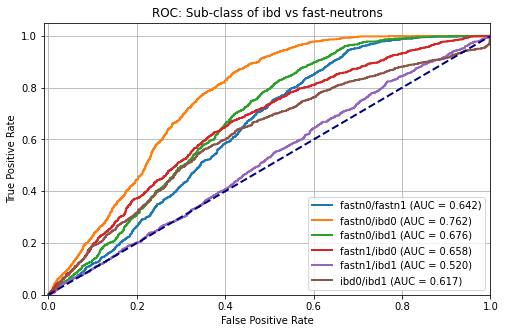

In [373]:
cat1 = [0, 0, 0, 1, 1, 2]
cat2 = [1, 2, 3, 2, 3, 3]
labels = ['fastn0/fastn1', 'fastn0/ibd0', 'fastn0/ibd1', 
          'fastn1/ibd0', 'fastn1/ibd1', 
          'ibd0/ibd1', 
         ]

plt.figure(figsize=(8,5))
for i, j, label in zip(cat1, cat2, 
                        labels,
                         ):
    mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
    prob = scores[:, j][mask]
    
    guesses = y_test_2[mask]
    guesses = guesses - np.min(guesses)
    guesses = guesses/np.max(guesses)

    fpr, tpr, thresholds = roc_curve(guesses, prob)
        
    auc = roc_auc_score(y_test_2[mask], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Sub-class of ibd vs fast-neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.show()

## Non-sequential Model

In [452]:
from keras.layers import Concatenate, Flatten
from keras.models import Model


In [447]:
model2 = Sequential()
# create the model
model2.add(InputLayer(42))
model2.compile()

In [572]:
regressor2 = Sequential()
input_shape = X2.shape[1:]
regressor2.add(InputLayer(input_shape=input_shape))
regressor2.add(LSTM(units=256, 
                   return_sequences=True, 
                   dropout=0.1,
                  ))  

regressor2.add(LSTM(units=128, 
                   return_sequences=True, 
                   dropout=0.1, 
                   
                  ))
regressor2.add(LSTM(units=64, 
                   return_sequences=False, 
                   dropout=0.1, 
                   
                  ))
regressor2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 200, 256)          269312    
_________________________________________________________________
lstm_20 (LSTM)               (None, 200, 128)          197120    
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                49408     
Total params: 515,840
Trainable params: 515,840
Non-trainable params: 0
_________________________________________________________________


In [573]:
mergedOut = Concatenate()([regressor2.output,model2.output])

In [579]:
mergedOut = Flatten()(mergedOut)    
mergedOut = Dense(128, activation='relu')(mergedOut)
mergedOut = Dropout(.3)(mergedOut)
mergedOut = Dense(64, activation='relu')(mergedOut)
mergedOut = Dropout(.3)(mergedOut)

# output layer
mergedOut = Dense(3, activation='softmax')(mergedOut)


In [580]:
newModel = Model([regressor2.input,model2.input], mergedOut)
    #use lists if you want more than one input or output    
newModel.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 200, 256)     269312      input_18[0][0]                   
__________________________________________________________________________________________________
lstm_20 (LSTM)                  (None, 200, 128)     197120      lstm_19[0][0]                    
__________________________________________________________________________________________________
lstm_21 (LSTM)                  (None, 64)           49408       lstm_20[0][0]                    
____________________________________________________________________________________________

In [581]:
newModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [501]:
all_data = ak.concatenate([ibd, fastn])

In [582]:
samples = min([ak.count_nonzero(fn), 
#               ak.count_nonzero(fastn1_mask), 
              ak.count_nonzero(ibd0_mask), 
              ak.count_nonzero(ibd1_mask)])

In [578]:
fn = all_data['code']==2
invbeta = all_data['code']==1
id0 = all_data['subid']==0
id1p = all_data['subid']>0 # >0 changes things 

In [382]:
ibd0_mask = ak.from_iter([all(t) for t in zip(invbeta, id0)])
ibd1_mask = ak.from_iter([all(t) for t in zip(invbeta, id1p)])
fastn0_mask = ak.from_iter([all(t) for t in zip(fn, id0)])
fastn1_mask = ak.from_iter([all(t) for t in zip(fn, id1p)])

In [583]:
x1 = all_data[fn][:samples]
# x1 = ak.concatenate((x1, all_data[fastn1_mask][:samples]), axis=0)
x1 = ak.concatenate((x1, all_data[ibd0_mask][:samples]), axis=0)
x1 = ak.concatenate((x1, all_data[ibd1_mask][:samples]), axis=0)

In [584]:
y1 = np.zeros(3*samples)
y1[samples:2*samples] = 1
y1[2*samples:3*samples] = 2
# y1[3*samples:] = 2

In [383]:
samples = min([ak.count_nonzero(fastn0_mask), 
              ak.count_nonzero(fastn1_mask), 
              ak.count_nonzero(ibd0_mask), 
              ak.count_nonzero(ibd1_mask)])

In [465]:
x1 = all_data[fastn0_mask][:samples]
x1 = ak.concatenate((x1, all_data[fastn1_mask][:samples]), axis=0)
x1 = ak.concatenate((x1, all_data[ibd0_mask][:samples]), axis=0)
x1 = ak.concatenate((x1, all_data[ibd1_mask][:samples]), axis=0)

In [419]:
y1 = np.zeros(4*samples)
y1[samples:2*samples] = 1
y1[2*samples:3*samples] = 2
y1[3*samples:] = 3

In [585]:
# eplus = get_dims(positrons, dimensions=dimensions)[:samples]
X1 = get_dims(x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

Remaining variables selected for analysis: 42


In [586]:
data_to_manipulate = [x1
                     ]

In [587]:
X2, y2 = prep_net_data(data_to_manipulate, prompt=True, restime=True, maxlen=200)

Running set 1 of 1


In [588]:
y = ak.to_numpy(y1)
a = np.array(y.astype(int))
b = np.zeros((a.size, a.max()+1), dtype='int32')
b[np.arange(a.size),a] = 1
y = b

In [589]:
# Split dataset into training set and test set
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(X1, X2, y, test_size=0.25, random_state=43) 

In [590]:
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

Typically seems to go down then slowly back up.. maybe training on the dense part too fast and propagating all errors there? give it more time maybe? 

In [591]:
history2 = newModel.fit([X_train2, X_train1], y_train,
          validation_data=([X_test2, X_test1], y_test),
          epochs=20, batch_size=64, 
         )

Epoch 1/20
  8/606 [..............................] - ETA: 7:51 - loss: 1.1007 - accuracy: 0.3289

KeyboardInterrupt: 

## Multiple Regressor

In [156]:
samples = np.min([len(fastn), len(ibd)])
data_to_manipulate = [fastn[:samples], ibd[:samples]]

In [157]:
vector_length=200

In [158]:
X, y = prep_net_data(data_to_manipulate, 
                     prompt=True, restime=True, maxlen=vector_length)

Running set 1 of 2


ValueError: could not broadcast input array from shape (25469,200,3) into shape (25469,200,2)

In [704]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

In [737]:
regressor = Sequential()

regressor.add(InputLayer(input_shape=(vector_length,5)))
regressor.add(LSTM(units=256, 
                   return_sequences=True, 
                   dropout=0.1,
                  ))  

regressor.add(LSTM(units=128, 
                   return_sequences=True, 
                   dropout=0.1, 
                   
                  ))

regressor.add(LSTM(units=64, 
                   return_sequences=True, 
                  dropout=0.0, 
                  ))

regressor.add(LSTM(units=32, 
                   return_sequences=False, 
                  dropout=0.0, 
                  ))

# regressor.add(Dense(128, 
#                     activation='relu', 
#                    ))

# regressor.add(Dropout(0.2))

regressor.add(Dense(32, 
                   activation='relu', 
                   ))

regressor.add(Dense(1, activation='sigmoid'))

regressor.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [738]:
regressor.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 150, 256)          268288    
_________________________________________________________________
lstm_96 (LSTM)               (None, 150, 128)          197120    
_________________________________________________________________
lstm_97 (LSTM)               (None, 150, 64)           49408     
_________________________________________________________________
lstm_98 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 33        
Total params: 528,321
Trainable params: 528,321
Non-trainable params: 0
_______________________________________________

In [744]:
history = regressor.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=20, batch_size=64, 
         )

Epoch 1/20
503/503 [==============================] - 376s 748ms/step - loss: 0.4782 - accuracy: 0.7642 - val_loss: 0.4950 - val_accuracy: 0.7527
Epoch 2/20
503/503 [==============================] - 375s 745ms/step - loss: 0.4734 - accuracy: 0.7672 - val_loss: 0.4929 - val_accuracy: 0.7552
Epoch 3/20
503/503 [==============================] - 376s 748ms/step - loss: 0.4721 - accuracy: 0.7694 - val_loss: 0.4923 - val_accuracy: 0.7549
Epoch 4/20
503/503 [==============================] - 376s 747ms/step - loss: 0.4692 - accuracy: 0.7720 - val_loss: 0.4954 - val_accuracy: 0.7562
Epoch 5/20
503/503 [==============================] - 375s 745ms/step - loss: 0.4675 - accuracy: 0.7733 - val_loss: 0.5102 - val_accuracy: 0.7572
Epoch 6/20
503/503 [==============================] - 376s 748ms/step - loss: 0.4649 - accuracy: 0.7745 - val_loss: 0.4942 - val_accuracy: 0.7567
Epoch 7/20
503/503 [==============================] - 376s 747ms/step - loss: 0.4607 - accuracy: 0.7776 - val_loss: 0.4958 -

In [745]:
scores = regressor.predict(X_test)
y_pred = np.round(scores)

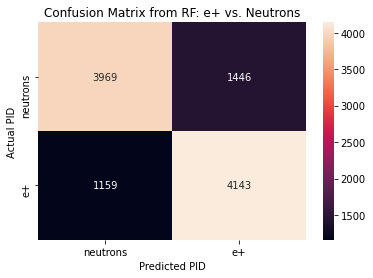

In [746]:
confmat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: e+ vs. Neutrons')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['neutrons', 'e+'])
ax.yaxis.set_ticklabels(['neutrons', 'e+'])

plt.show()

In [747]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

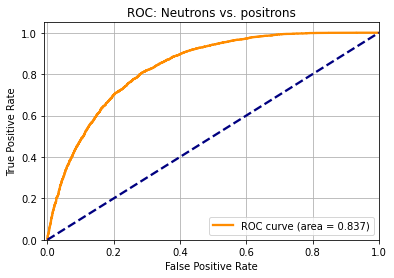

In [748]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Neutrons vs. positrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
# plt.xlim([1e-6, 1.0])
# plt.ylim([1e-2, 1.05])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

## Brief try at dense nn

In [ ]:
from keras.layers import LeakyReLU

In [147]:
model = Sequential()
# create the model
model.add(InputLayer(42))
model.add(Dense(256))
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               11008     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)               

In [149]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=10, batch_size=32, 
         )

Epoch 1/10
1194/1194 [==============================] - 4s 3ms/step - loss: 0.4292 - accuracy: 0.7771 - val_loss: 0.4280 - val_accuracy: 0.7746
Epoch 2/10
1194/1194 [==============================] - 4s 3ms/step - loss: 0.4271 - accuracy: 0.7766 - val_loss: 0.4346 - val_accuracy: 0.7719
Epoch 3/10
1194/1194 [==============================] - 4s 3ms/step - loss: 0.4269 - accuracy: 0.7767 - val_loss: 0.4314 - val_accuracy: 0.7697
Epoch 4/10
1194/1194 [==============================] - 4s 3ms/step - loss: 0.4276 - accuracy: 0.7776 - val_loss: 0.4359 - val_accuracy: 0.7709
Epoch 5/10
1194/1194 [==============================] - 4s 3ms/step - loss: 0.4267 - accuracy: 0.7790 - val_loss: 0.4317 - val_accuracy: 0.7726
Epoch 6/10
1194/1194 [==============================] - 4s 3ms/step - loss: 0.4257 - accuracy: 0.7778 - val_loss: 0.4308 - val_accuracy: 0.7746
Epoch 7/10
1194/1194 [==============================] - 4s 3ms/step - loss: 0.4247 - accuracy: 0.7786 - val_loss: 0.4332 - val_accuracy:

---------

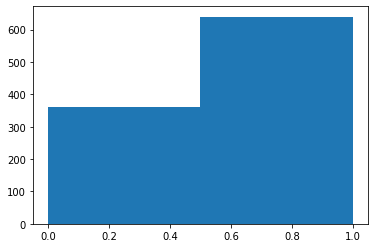

In [88]:
plt.hist(wrongibd['subid'], bins=2)
plt.show()

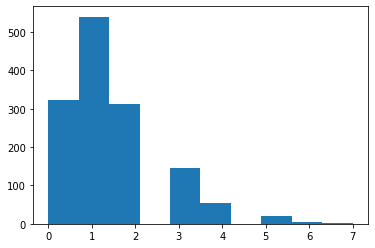

In [89]:
plt.hist(wrongfastn['subid'])
plt.show()

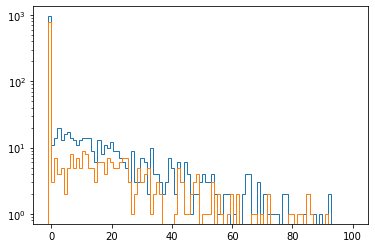

In [90]:
kw = dict(bins=np.linspace(-1,100,100), histtype='step')
plt.hist(wrongfastn['dt_prev_us'], **kw)
plt.hist(wrongibd['dt_prev_us'], **kw)
plt.yscale('log')
plt.show()

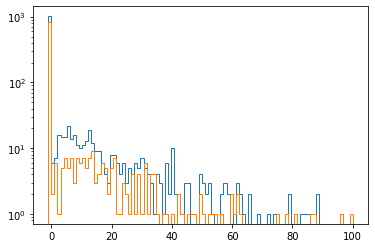

In [91]:
kw = dict(bins=np.linspace(-1,100,100), histtype='step')
plt.hist(wrongfastn['dt_next_us'], **kw)
plt.hist(wrongibd['dt_next_us'], **kw)
plt.yscale('log')
plt.show()

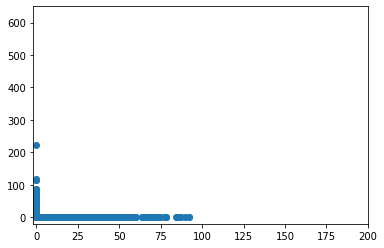

In [92]:
plt.scatter(wrongfastn['dt_prev_us'],wrongfastn['dt_next_us'], 
#             c=rightpred
           )
plt.ylim(-20,650)
plt.xlim(-2, 200)
plt.show()